In [2]:
import tifffile
import skimage.measure
import zarr
from scipy import ndimage
from skimage import morphology
import numpy as np
from matplotlib import pyplot as plt
import napari
import pandas as pd

In [3]:
sm_tif = tifffile.TiffFile("exemplar-001/segmentation/unmicst-exemplar-001/cell.ome.tif", mode="rb")

In [4]:
sm = zarr.open(sm_tif.aszarr(), mode="r")[0]

In [5]:
sm

<zarr.core.Array '/0' (3139, 2511) int32 read-only>

In [6]:
ndimage.find_objects(np.array([1, 3, 5]))

[(slice(0, 1, None),), None, (slice(1, 2, None),), None, (slice(2, 3, None),)]

In [28]:
sm_tif.series[0].nbytes

31528116

In [7]:
r, fw, rv = skimage.segmentation.relabel_sequential(np.array([1, 3, 5]))

In [15]:
rv.out_values

array([1, 3, 5])

In [523]:
sm.dtype

dtype('int32')

In [5]:
np.unique(sm)

array([    0,     1,     2, ..., 11168, 11169, 11170], dtype=int32)

In [16]:
im_tif = tifffile.TiffFile("exemplar-001/registration/exemplar-001.ome.tif", mode="rb")

In [17]:
im_tif.series[0].nbytes

189168696

In [20]:
im = zarr.open(im_tif.aszarr(), mode="r")[0]

In [21]:
im.chunks

(1, 1024, 1024)

In [22]:
z = zarr.array(np.arange(27).reshape(3, 3, 3))

In [23]:
z[...]

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [24]:
z.oindex[np.array([[True, False, True], [False, True, False], [False, False, True]]), :]

IndexError: Boolean arrays in an orthogonal selection must be 1-dimensional only

In [25]:
bg = sm[...] == 0

In [9]:
dist, (i, j) = ndimage.distance_transform_edt(
    bg, return_indices=True
)

In [10]:
dist.shape

(3139, 2511)

In [11]:
sm_mod = sm[...]

In [12]:
bg

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

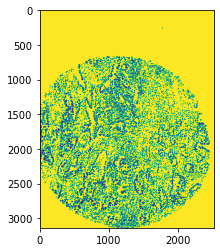

In [13]:
plt.imshow(bg)

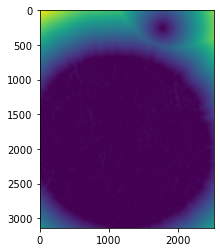

In [14]:
plt.imshow(dist)

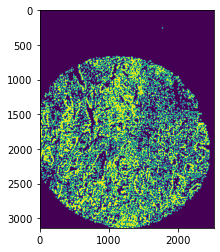

In [15]:
plt.imshow(dist <= 3)

In [16]:
cm = sm[...] != 0

In [17]:
dist, (i, j) = ndimage.distance_transform_edt(
    cm, return_indices=True
)

In [18]:
dist.shape

(3139, 2511)

In [19]:
cm

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

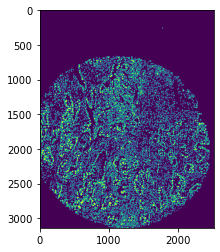

In [20]:
plt.imshow(cm)

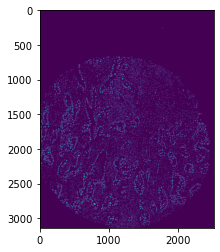

In [21]:
plt.imshow(dist)

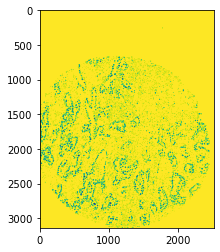

In [22]:
plt.imshow(dist <= 3)

In [26]:
viewer_1 = napari.view_image(sm)

In [251]:
viewer_1.add_image(im)

<Image layer 'im' at 0x1c27b6bf0>

In [24]:
viewer_1.add_image(dist)

<Image layer 'dist' at 0x1aa8ffca0>

In [198]:
viewer_1.add_image(sm)

<Image layer 'sm' at 0x1dbc66c20>

In [10]:
from skimage.measure._regionprops import RegionProperties, _props_to_dict

In [11]:
import pdb

In [473]:
def erode_mask(mask, radius):
    mask_out = mask.copy()
    dist = ndimage.distance_transform_edt(mask != 0)
    mask_out[dist <= radius] = 0
    return mask_out


class LazyExpandedRegions:
    def __init__(self, label_image, intensity_image, radius, extra_properties=None):
        # Copy because we will keep modifying it
        self.label_image = label_image.copy()
        self.intensity_image = intensity_image
        self.radius = radius
        self.objects = ndimage.find_objects(label_image)
        self.extra_properties = extra_properties
        self.footprint = morphology.disk(self.radius)
        
    def find_contours(self):
        contours = []
        for i in range(len(self.objects)):
            sl, mask = self.get_expanded_cell_mask(i)
            mask = ndimage.binary_fill_holes(mask)
            contour = skimage.measure.find_contours(
                mask, level=0.5, fully_connected="high"
            )
            contour = np.concatenate(contour, axis=0)
            # contour = np.flip(contour, axis=1)
            # contour = cv2.findContours(
            #     mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=[x.start for x in sl]
            # )[0][0][:, 0, :]
            contour += np.array([x.start for x in sl])
            # contour[:, 1] = sl[1].stop - contour[:, 1]
            contours.append(contour)
        return contours
    
    def get_expanded_cell_mask(self, x):
        label = x + 1
        sl = self.objects[x]
        sl_expanded = tuple(
            slice(
                max(0, x.start - self.radius - 1),
                min(self.label_image.shape[i], x.stop + self.radius + 1)
            ) for i, x in enumerate(sl)
        )
        li_target = self.label_image[sl_expanded] == label
        if self.radius > 0:
            li_target = morphology.binary_dilation(
                li_target, footprint=self.footprint
            )
        return sl_expanded, li_target
        
    def __getitem__(self, x):
        label = x + 1
        sl_expanded, li_target = self.get_expanded_cell_mask(x)
        li_orig = self.label_image[sl_expanded]
        li_repl = li_orig.copy()
        li_repl[li_repl != label] = 0
        li_repl[li_target] = label
        try:
            self.label_image[sl_expanded] = li_repl
            return RegionProperties(
                sl_expanded, label, self.label_image, self.intensity_image,
                cache_active=True, extra_properties=self.extra_properties
            )
        finally:
            self.label_image[sl_expanded] = li_orig

    def __len__(self):
        return len(self.objects)
    



def regionprops_tidal(label_image, intensity_image, radii, **kwargs):
    prop_tables = {}
    
    for r in radii:
        if r < 0:
            mask = erode_mask(label_image, radius = abs(r))
            prop_tables[r] = skimage.measure.regionprops_table(
                mask, intensity_image, **kwargs
            )
        elif r == 0:
            prop_tables[r] = skimage.measure.regionprops_table(
                label_image, intensity_image, **kwargs
            )
        else:
            extra_properties = kwargs.get("extra_properties", None)
            properties = kwargs.get("properties", ("label", "bbox"))
            if extra_properties is not None:
                properties = list(properties) + [x.__name__ for x in extra_properties]
            prop_tables[r] = _props_to_dict(
                LazyExpandedRegions(
                    label_image, intensity_image, r, extra_properties=extra_properties
                ),
                properties=properties,
                separator=kwargs.get("separator", "-")
            )
    return prop_tables

In [389]:
x = erode_mask(sm[0][...], 2)

In [33]:
 np.moveaxis(im[0][...], 0, -1).shape

(2511, 3139)

In [34]:
im

<zarr.core.Array '/0' (12, 3139, 2511) uint16 read-only>

In [390]:
x

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [36]:
sm[0][...].shape

(2511,)

In [137]:
%pdb

Automatic pdb calling has been turned OFF


In [37]:
def intensity_sum(label_image, intensity_image):
    return np.sum(intensity_image[label_image])

In [38]:
res = regionprops_tidal(
    sm[...], np.moveaxis(im[...], 0, -1), [-4, -2, 0, 2, 4], properties=("area", "intensity_mean"), extra_properties=[intensity_sum]
)

/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [40]:
res[-4]

{'area': array([15,  7, 60, ...,  6, 21,  5]),
 'intensity_mean-0': array([23206.26666667, 23143.14285714, 28364.18333333, ...,
        30891.        , 13981.9047619 , 24580.4       ]),
 'intensity_mean-1': array([1346.        , 1259.71428571, 1291.41666667, ..., 1340.5       ,
        1209.04761905, 1220.        ]),
 'intensity_mean-2': array([177.4       , 210.42857143, 205.7       , ..., 249.        ,
        192.        , 251.6       ]),
 'intensity_mean-3': array([ 527.26666667,  706.71428571,  891.68333333, ...,  897.33333333,
        1218.66666667,  966.6       ]),
 'intensity_mean-4': array([ 7771.26666667, 14963.42857143, 17452.61666667, ...,
        16246.16666667,  8620.76190476, 15212.2       ]),
 'intensity_mean-5': array([415.66666667, 929.71428571, 874.11666667, ..., 609.16666667,
        820.71428571, 704.6       ]),
 'intensity_mean-6': array([ 269.86666667,  434.28571429, 2706.35      , ...,  813.33333333,
         975.66666667, 1099.8       ]),
 'intensity_mean-7': a

In [41]:
y = pd.concat([pd.DataFrame.from_dict(x) for x in res.values()], keys=res.keys(), names=["tide_radius", "row_id"])

In [43]:
y.reset_index(inplace=True)

In [44]:
y.to_csv("test_tide.csv")

In [66]:
rps =  regionprops_tidal(
    sm[...], np.moveaxis(im[...], 0, -1), [-4, -2, 0, 2, 4], properties=("area", "intensity_mean"), extra_properties=[intensity_sum]
)

/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [45]:
res_polys = regionprops_tidal(
    sm[...], np.moveaxis(im[...], 0, -1), [0], properties=("area", "intensity_mean"), extra_properties=[intensity_sum]
)

In [486]:
res = LazyExpandedRegions(
    sm[...], np.moveaxis(im[...], 0, -1), radius=1
)

In [487]:
contours = res.find_contours()

In [430]:
contours[1].shape

(55, 2)

In [431]:
x, y = res.get_expanded_cell_mask(7)

In [432]:
x

(slice(668, 682, None), slice(993, 1012, None))

In [433]:
y_shape = Polygon(contours[7])

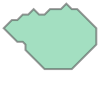

In [434]:
y_shape

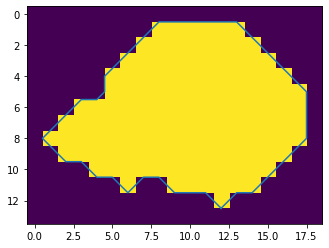

In [435]:
plt.plot(contours[7][:, 0] - x[0].start, contours[7][:, 1] - x[1].start)
plt.imshow(y)

In [13]:
import cv2

In [616]:
y_cv2 = cv2.findContours(y.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0][:, 0, :]

In [624]:
y_cv2

array([[10,  1],
       [ 9,  2],
       [ 8,  2],
       [ 6,  4],
       [ 6,  5],
       [ 4,  7],
       [ 3,  7],
       [ 2,  8],
       [ 2,  9],
       [ 1, 10],
       [ 2, 11],
       [ 2, 12],
       [ 3, 12],
       [ 4, 13],
       [ 5, 13],
       [ 6, 14],
       [ 7, 14],
       [ 8, 15],
       [ 9, 14],
       [10, 14],
       [11, 15],
       [13, 15],
       [14, 16],
       [15, 15],
       [16, 15],
       [17, 14],
       [18, 14],
       [20, 12],
       [20, 11],
       [21, 10],
       [21,  7],
       [20,  6],
       [20,  5],
       [17,  2],
       [16,  2],
       [15,  1]], dtype=int32)

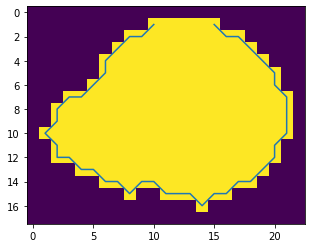

In [617]:
plt.plot(y_cv2[:, 0], y_cv2[:, 1])
plt.imshow(y)

In [319]:
np.array(y_shape.exterior.coords)

array([[1005. ,  682.5],
       [1004.5,  682. ],
       [1004. ,  681.5],
       [1003. ,  681.5],
       [1002. ,  681.5],
       [1001.5,  681. ],
       [1001. ,  680.5],
       [1000. ,  680.5],
       [ 999.5,  681. ],
       [ 999. ,  681.5],
       [ 998.5,  681. ],
       [ 998. ,  680.5],
       [ 997. ,  680.5],
       [ 996.5,  680. ],
       [ 996. ,  679.5],
       [ 995. ,  679.5],
       [ 994.5,  679. ],
       [ 994. ,  678.5],
       [ 993. ,  678.5],
       [ 992.5,  678. ],
       [ 992.5,  677. ],
       [ 992. ,  676.5],
       [ 991.5,  676. ],
       [ 992. ,  675.5],
       [ 992.5,  675. ],
       [ 992.5,  674. ],
       [ 993. ,  673.5],
       [ 993.5,  673. ],
       [ 994. ,  672.5],
       [ 995. ,  672.5],
       [ 995.5,  672. ],
       [ 996. ,  671.5],
       [ 996.5,  671. ],
       [ 996.5,  670. ],
       [ 997. ,  669.5],
       [ 997.5,  669. ],
       [ 998. ,  668.5],
       [ 998.5,  668. ],
       [ 999. ,  667.5],
       [1000. ,  667.5],


In [320]:
np.flip(contours[7], 1) == np.array(y_shape.exterior.coords)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr

In [636]:
y_reconstructed = rasterio.features.rasterize(
    [shapely.affinity.translate(y_shape, -x[1].start + 0.5, -x[0].start + 0.5)],
    out_shape=(x[0].stop - x[0].start, x[1].stop - x[1].start),
    fill=0,
    all_touched=False
)

In [632]:
shapely.affinity.translate(y_shape, -x[1].start + 0.5, -x[0].start + 0.5).exterior.bounds

(1.0, 1.0, 22.0, 17.0)

In [633]:
(x[0].stop - x[0].start, x[1].stop - x[1].start)

(18, 23)

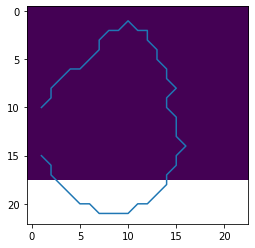

In [637]:
plt.imshow(
y_reconstructed
)
plt.plot(contours[7][:, 1] - x[1].start, contours[7][:, 0] - x[0].start)

In [525]:
contours[7][:, 1] - x[1].start, contours[7][:, 0] - x[0].start

(array([14. , 13.5, 13. , 12. , 11. , 10.5, 10. ,  9. ,  8.5,  8. ,  7.5,
         7. ,  6. ,  5.5,  5. ,  4. ,  3.5,  3. ,  2. ,  1.5,  1.5,  1. ,
         0.5,  1. ,  1.5,  1.5,  2. ,  2.5,  3. ,  4. ,  4.5,  5. ,  5.5,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  9. ,  9.5, 10. , 11. , 12. ,
        13. , 14. , 15. , 15.5, 16. , 17. , 17.5, 18. , 18.5, 19. , 19.5,
        20. , 20.5, 20.5, 21. , 21.5, 21.5, 21.5, 21.5, 21. , 20.5, 20.5,
        20. , 19.5, 19. , 18.5, 18. , 17. , 16.5, 16. , 15. , 14.5, 14. ]),
 array([16.5, 16. , 15.5, 15.5, 15.5, 15. , 14.5, 14.5, 15. , 15.5, 15. ,
        14.5, 14.5, 14. , 13.5, 13.5, 13. , 12.5, 12.5, 12. , 11. , 10.5,
        10. ,  9.5,  9. ,  8. ,  7.5,  7. ,  6.5,  6.5,  6. ,  5.5,  5. ,
         4. ,  3.5,  3. ,  2.5,  2. ,  1.5,  1.5,  1. ,  0.5,  0.5,  0.5,
         0.5,  0.5,  0.5,  1. ,  1.5,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,
         4.5,  5. ,  6. ,  6.5,  7. ,  8. ,  9. , 10. , 10.5, 11. , 12. ,
        12.5, 13. , 13.5, 14. , 14.5

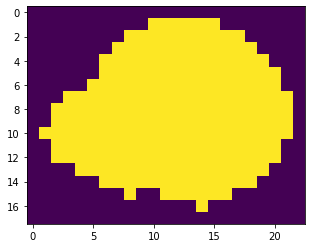

In [340]:
plt.imshow(y)

In [347]:
def rg(img1, img2):
    assert img1.shape == img2.shape
    out = np.empty(img1.shape + (3,), dtype=np.float32)
    out[...,0] = skimage.util.img_as_float32(img1)
    out[...,1] = skimage.util.img_as_float32(img2)
    out[...,2] = 0
    return out

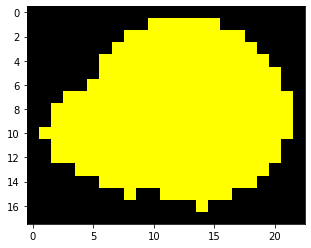

In [348]:
plt.imshow(
    rg(
        y_reconstructed.astype(bool),
        y
    )
)

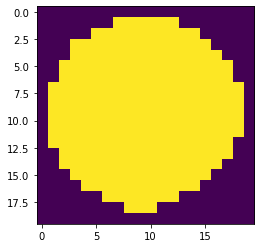

In [150]:
plt.imshow(res.get_expanded_cell_mask(0)[1])

In [14]:
import shapely
from shapely.geometry import Polygon, MultiPolygon, JOIN_STYLE
from shapely.strtree import STRtree

In [478]:
JOIN_TOLERANCE = 0.001

def find_intersections(contours):
    polygons = {i: Polygon(x) for i, x in enumerate(contours) if x.shape[0] >= 3}
    tree = STRtree(polygons.values())
    tree_map = {id(x): i for i, x in polygons.items()}
    intersections = {}
    for i, x in polygons.items():
        res = tree.query(x)
        for y in res:
            j = tree_map[id(y)]
            if i == j:
                continue
            key = tuple(sorted((i, j)))
            if key not in intersections:
                intersection = x.intersection(y)
                # Sometimes intersections contain small "slivers" of polygons with almost zero
                # area. Removing them
                # https://gis.stackexchange.com/a/120314
                intersection_fixed = intersection.buffer(
                    JOIN_TOLERANCE, 1, join_style=JOIN_STYLE.mitre
                ).buffer(
                    -JOIN_TOLERANCE, 1, join_style=JOIN_STYLE.mitre
                )
                if intersection_fixed.area == 0:
                    intersections[key] = None
                    continue
                # if isinstance(intersection_fixed, Polygon):
                #     c = np.array(intersection_fixed.exterior.coords)
                #     c = np.around(c * 2) / 2
                #     intersection_snapped = Polygon(c)
                # elif isinstance(intersection_fixed, MultiPolygon):
                #     ps = []
                #     for p in intersection_fixed.geoms:
                #         c = np.array(p.exterior.coords)
                #         c = np.around(c * 2) / 2
                #         ps.append(Polygon(c))
                #     intersection_snapped = MultiPolygon(ps)
                # else:
                #     raise RuntimeError()
                intersections[key] = intersection_fixed
    for k in list(intersections.keys()):
        if intersections[k] is None:
            del intersections[k]
    return intersections

In [488]:
intersections = find_intersections(contours)

In [111]:
intersections

{(1, 2): <shapely.geometry.polygon.Polygon at 0x1d6ab2860>,
 (2, 13): <shapely.geometry.polygon.Polygon at 0x1d6ab2890>,
 (2, 14): <shapely.geometry.polygon.Polygon at 0x1d6ab28c0>,
 (3, 6): <shapely.geometry.polygon.Polygon at 0x1d6ab28f0>,
 (3, 22): <shapely.geometry.polygon.Polygon at 0x1d6ab2920>,
 (3, 15): <shapely.geometry.polygon.Polygon at 0x1d6ab2950>,
 (3, 7): <shapely.geometry.polygon.Polygon at 0x1d6ab2980>,
 (4, 14): <shapely.geometry.polygon.Polygon at 0x1d6ab29b0>,
 (5, 24): <shapely.geometry.polygon.Polygon at 0x1d6ab29e0>,
 (5, 25): <shapely.geometry.polygon.Polygon at 0x1d6ab2a10>,
 (7, 22): <shapely.geometry.polygon.Polygon at 0x1d6ab2a40>,
 (7, 15): <shapely.geometry.polygon.Polygon at 0x1d6ab2a70>,
 (9, 11): <shapely.geometry.polygon.Polygon at 0x1d6ab2aa0>,
 (12, 31): <shapely.geometry.polygon.Polygon at 0x1d6ab2ad0>,
 (13, 33): <shapely.geometry.polygon.Polygon at 0x1d6ab2b00>,
 (15, 22): <shapely.geometry.polygon.Polygon at 0x1d6ab2b30>,
 (16, 28): <shapely.geom

In [489]:
import collections
collections.Counter(str(type(x)) for x in intersections.values())

Counter({"<class 'shapely.geometry.polygon.Polygon'>": 6289,
         "<class 'shapely.geometry.multipolygon.MultiPolygon'>": 1})

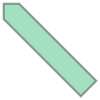

In [490]:
intersections[(3, 7)]

In [676]:
np.array(intersections[(3, 7)].exterior.coords)

array([[994. , 679. ],
       [995. , 678. ],
       [996. , 678. ],
       [997. , 677. ],
       [998. , 677. ],
       [998. , 676. ],
       [999. , 675. ],
       [998. , 674. ],
       [998. , 673. ],
       [996.5, 671.5],
       [996. , 672. ],
       [995. , 672. ],
       [993. , 674. ],
       [993. , 675. ],
       [992. , 676. ],
       [992. , 679. ],
       [994. , 679. ]])

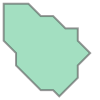

In [670]:
shapely.affinity.scale(intersections[(3, 7)], 2, 2, origin="centroid")

In [206]:
x = shapely.affinity.scale(intersections[(3, 7)], 2, 2, origin="centroid")

In [207]:
x.area

128.0

In [208]:
intersections[(3, 7)].area

32.0

In [163]:
intersections[(3, 7)].bounds

(670.0, 991.5, 679.0, 998.5)

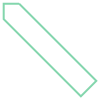

In [118]:
x.exterior

In [74]:
len(intersections)

9504

In [127]:
x.bounds

(672.063492063492, 991.936507936508, 678.063492063492, 997.936507936508)

In [21]:
import rasterio.features

In [22]:
def shape_to_mask(shape, pad=0):
    bounds = np.array(shape.bounds) # + np.array([-0.5, -0.5, 0.5, 0.5])
    # print(f"raw bounds {bounds}")
    frac = np.modf(bounds)[0]
    ends_half = np.isclose(frac, 0.5)
    if not ends_half[0]:
        bounds[0] -= 0.5
    if not ends_half[1]:
        bounds[1] -= 0.5
    if not ends_half[2]:
        bounds[2] += 0.5
    if not ends_half[3]:
        bounds[3] += 0.5
    # bounds = np.array([
    #     np.floor(bounds[0] * 2) / 2,
    #     np.floor(bounds[1] * 2) / 2,
    #     np.ceil(bounds[2] * 2) / 2,
    #     np.ceil(bounds[3] * 2) / 2,
    # ])
    # print(bounds)
    if pad != 0:
        bounds[0] -= pad
        bounds[1] -= pad
        bounds[2] += pad
        bounds[3] += pad
    # print(f"bounds {bounds}")
    # mask_shape = np.rint([
    #     bounds[3] - bounds[1],
    #     bounds[2] - bounds[0]
    # ]).astype(int)
    mask_shape = np.array([
        bounds[3] - bounds[1],
        bounds[2] - bounds[0]
    ]).astype(int)
    # print(f"mask shape {mask_shape}")
    shape_trans = shapely.affinity.translate(shape, -bounds[0], -bounds[1])
    # print(f"trans bounds {shape_trans.bounds}")
    mask = rasterio.features.rasterize(
        [shape_trans],
        out_shape=mask_shape,
        fill=0, all_touched=True
    )
    # print(f"final mask shape {mask.shape}")
    return mask

def plot_reconstruction(shape, pad=0, original=None):
    mask = shape_to_mask(shape, pad)
    c = np.array(
        shapely.affinity.translate(
            shape,
            -shape.bounds[0],
            -shape.bounds[1]
        ).exterior.coords
    ) + pad
    print(f"coords x {c[:, 0].min()} {c[:, 0].max()} y {c[:, 1].min()} {c[:, 1].max()}")
    if original is None:
        plt.imshow(mask)
    else:
        plt.imshow(rg(
            original,
            mask.astype(bool)
        ))
    plt.plot(
        c[:, 0], c[:, 1]
    )
    plt.scatter(c[:, 0].max(), c[:, 1].max())
    # return c

In [23]:
plot_reconstruction(y_shape, pad=0)

NameError: name 'y_shape' is not defined

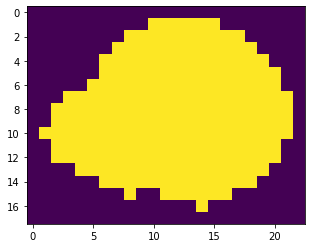

In [754]:
plt.imshow(y)

In [739]:
shape_to_mask(y_shape, 1).shape

[ 666.5  991.5  687.5 1007.5]


(18, 23)

In [740]:
y.shape

(18, 23)

raw bounds [ 667.  992.  687. 1007.]
bounds [ 665.5  990.5  688.5 1008.5]
mask shape [18 23]
trans bounds (1.5, 1.5, 21.5, 16.5)
final mask shape (18, 23)


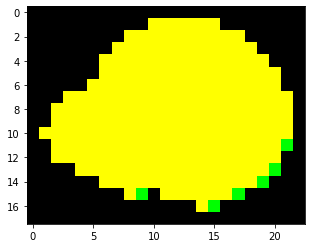

In [793]:
plt.imshow(rg(
    y,
    shape_to_mask(y_shape, 1).astype(bool)
))

In [ ]:
rasterio.features.rasterize(
        [shape_trans],
        out_shape=mask_shape,
        fill=0, all_touched=False
    )

In [483]:
intersections

{}

In [663]:
plot_reconstruction(intersections[(18, 19)], 0)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

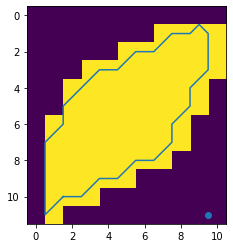

In [714]:
plot_reconstruction(intersections[(46, 57)], 1)

In [715]:
plot_reconstruction(y_shape, 0, y[1:-1, 1:-1])

AssertionError: 

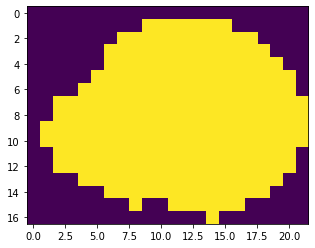

In [719]:
plt.imshow(shape_to_mask(y_shape, 1))

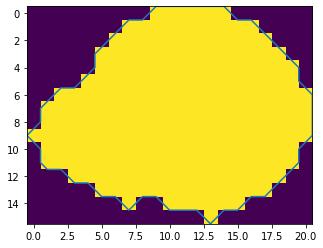

In [488]:
plt.imshow(shape_to_mask(y_shape, 0))
c = np.array(
    shapely.affinity.translate(
        y_shape,
        -y_shape.bounds[0],
        -y_shape.bounds[1]
    ).exterior.coords
)
plt.plot(
    c[:, 0] - 0.5, c[:, 1] - 0.5
)

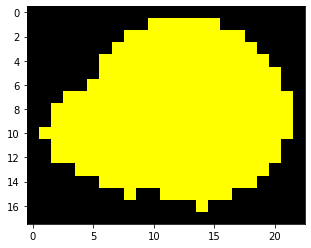

In [ ]:
plt.imshow(
    rg(
        shape_to_mask(y_shape, 1).astype(bool),
        y
    )
)

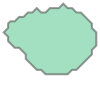

In [485]:
y_shape.

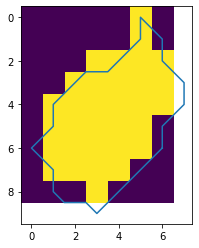

In [490]:
plt.imshow(shape_to_mask(intersections[(3, 7)], 0))
c = np.array(
    shapely.affinity.translate(
        intersections[(3, 7)],
        -intersections[(3, 7)].bounds[0],
        -intersections[(3, 7)].bounds[1]
    ).exterior.coords
)
plt.plot(
    c[:, 0], c[:, 1]
)

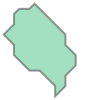

In [481]:
intersections[(3, 7)]

In [24]:
from collections import defaultdict
from itertools import pairwise

In [383]:
def place_mask(mask_slice, target_slice, mask):
    # print(f"mask slice {mask_slice} target_slice {target_slice} mask shape {mask.shape}")
    target_shape = (target_slice[2] - target_slice[0], target_slice[3] - target_slice[1])
    # print(f"target_shape {target_shape}")
    x = np.zeros(target_shape, dtype=mask.dtype)
    place_slice = np.array([
        mask_slice[0] - target_slice[0],
        mask_slice[1] - target_slice[1],
        mask_slice[2] - target_slice[0],
        mask_slice[3] - target_slice[1]
    ])
    # print(f"place_slice {place_slice}")
    x[place_slice[0]:place_slice[2], place_slice[1]:place_slice[3]] = mask
    return x


class IntersectionProfiler:
    def __init__(self, label_image, intensity_image, extra_properties=None):
        # Copy because we will keep modifying it
        self.label_image = label_image
        self.intensity_image = intensity_image
        self.objects = ndimage.find_objects(label_image)
        self.extra_properties = extra_properties
        self._footprints = {}

    def get_footprint(self, radius):
        try:
            return self._footprints[radius]
        except KeyError:
            self._footprints[radius] = morphology.disk(radius)
            return self._footprints[radius]

    def get_expanded_cell_mask(self, x, radius, crop_slice=None):
        label = x + 1
        if crop_slice is None:
            sl = self.objects[x]
            crop_slice = tuple(
                slice(
                    max(0, x.start - radius - 1),
                    min(self.label_image.shape[i], x.stop + radius + 1)
                ) for i, x in enumerate(sl)
            )
        # print(crop_slice)
        crop = self.label_image[crop_slice[0]:crop_slice[2], crop_slice[1]:crop_slice[3]] == label
        # print(crop.shape)
        crop = morphology.binary_dilation(
            crop, footprint=self.get_footprint(radius)
        )
        return crop_slice, crop

    def get_profile(self, ids, max_radius):
        sl1, sl2 = self.objects[ids[0]], self.objects[ids[1]]
        target_slice = np.array([
            min(sl1[0].start, sl2[0].start) - max_radius,
            min(sl1[1].start, sl2[1].start) - max_radius,
            max(sl1[0].stop, sl2[0].stop) + max_radius,
            max(sl1[1].stop, sl2[1].stop) + max_radius
        ])
        cell_masks = defaultdict(list)
        for i in range(2):
            for j in range(0, max_radius + 1):
                mask = self.get_expanded_cell_mask(ids[i], radius=j, crop_slice=target_slice)[1]
                cell_masks[i].append(mask)
        # print([c.shape for c in cell_masks[0]])
        # origin_slices = (cell_masks[0][max_radius][0], cell_masks[1][max_radius][0])
        # print(origin_slices)
        # target_slice = np.concatenate([
        #     np.minimum(origin_slices[0][:2], origin_slices[1][:2]),
        #     np.maximum(origin_slices[0][2:], origin_slices[1][2:])
        # ])
        # print(target_slice)
        # cell_masks_placed = {
        #     i: [place_mask(origin_slices[i], target_slice, m[1]) for m in masks] for i, masks in cell_masks.items()
        # }
        annuli = defaultdict(list)
        # annuli = {0: [cell_masks_placed[0]], 1: [cell_masks_placed[1]]}
        for i, masks in cell_masks.items():
            for m1, m2 in pairwise(reversed(masks)):
                annuli[i].append(np.bitwise_and(m1, ~m2))
        annuli[0].append(cell_masks[0][0])
        annuli[0].reverse()
        annuli[1].append(cell_masks[1][0])
        annuli[1].reverse()
        # print([x.shape for x in annuli[0]])
        profile_masks = []
        for i in reversed(range(2, max_radius + 1)):
            profile_masks.append(np.bitwise_and(annuli[0][i], annuli[1][0]))
        profile_masks.append(np.bitwise_and(annuli[0][1], annuli[1][1]))
        for i in range(2, max_radius + 1):
            profile_masks.append(np.bitwise_and(annuli[1][i], annuli[0][0]))
        # for i, j in zip(
        #     [0, 1] + list(range(1, max_radius + 1)),
        #     reversed([0, 1] + list(range(1, max_radius + 1)))
        # ):
        #     # print(i, j)
        #     profile_masks.append(np.bitwise_and(annuli[0][i], annuli[1][j]))
        # for i, a in annuli.items():
        #     for m in a:
        #         print(m.shape, cell_masks_placed[i][0].shape)
        #         profile_masks.append(np.bitwise_and(m, cell_masks_placed[1 - i][1]))
        x = self.intensity_image[target_slice[0]:target_slice[2], target_slice[1]:target_slice[3], :]
        # print(
        #     x.shape
        # )
        # print([p.shape for p in profile_masks])
        # print(
        #     # x[profile_masks[0][:, :, np.newaxis]]
        #     x[profile_masks[0], :]
        # )
        signal_means = np.stack([
            np.mean(
                # np.log2(
                    self.intensity_image[target_slice[0]:target_slice[2], target_slice[1]:target_slice[3]][p, :],
                # ),
                axis=0
            ) for p in profile_masks
        ])
        # signal_means = np.stack([
        #     np.mean(
        #         self.intensity_image[target_slice[0]:target_slice[2], target_slice[1]:target_slice[3]][p]
        #     )
        # ])
        return annuli, profile_masks, signal_means

In [384]:
np.moveaxis(im[...], 0, -1).shape

(3139, 2511, 12)

In [385]:
intersection_profiler = IntersectionProfiler(
    sm[...], np.moveaxis(im[...], 0, -1)
)

In [365]:
annuli, pmasks, signal_means = intersection_profiler.get_profile((3, 7), intersections[(3, 7)], 3)

In [366]:
signal_means

array([[ 8385.        ,   955.5       ,   181.25      ,   975.        ,
         4836.5       ,   787.        ,  1947.75      ,   369.5       ,
         5906.25      ,   864.        ,   266.25      ,   904.        ],
       [ 9416.5       ,   933.        ,   191.5       ,  1263.5       ,
         6045.        ,   875.        ,  2403.        ,   413.        ,
         6725.        ,   845.        ,   274.        ,   929.        ],
       [ 9960.66666667,   903.33333333,   184.66666667,  1060.66666667,
         6362.66666667,   800.66666667,  2076.66666667,   373.66666667,
         7083.        ,   839.        ,   201.33333333,   896.        ],
       [11618.        ,   967.33333333,   192.        ,   962.66666667,
         7621.        ,   785.66666667,  1957.66666667,   396.33333333,
         8258.33333333,   893.33333333,   259.33333333,   908.66666667],
       [12096.16666667,   958.33333333,   174.83333333,   635.        ,
         7841.        ,   675.5       ,  1391.5       ,   36

In [190]:
viewer = napari.view_image(
    np.stack(annuli[0])
)

In [191]:
viewer.add_image(np.stack(annuli[1]))

<Image layer 'Image [1]' at 0x194628850>

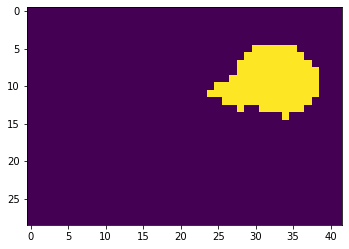

In [316]:
plt.imshow(annuli[1][0])

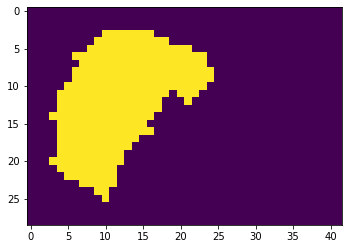

In [317]:
plt.imshow(annuli[0][0])

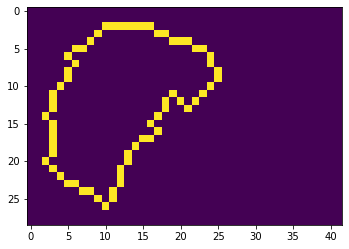

In [318]:
plt.imshow(annuli[0][1])

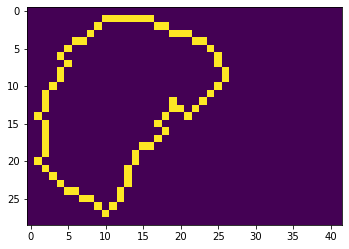

In [319]:
plt.imshow(annuli[0][2])

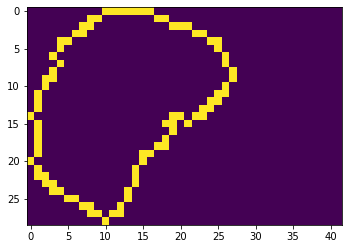

In [320]:
plt.imshow(annuli[0][3])

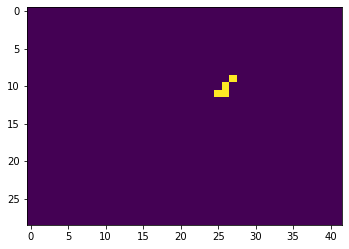

In [321]:
plt.imshow(pmasks[0])

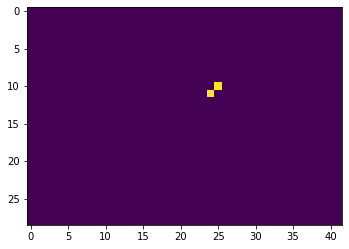

In [322]:
plt.imshow(pmasks[1])

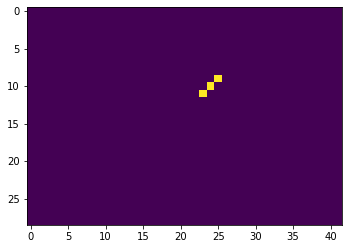

In [323]:
plt.imshow(pmasks[2])

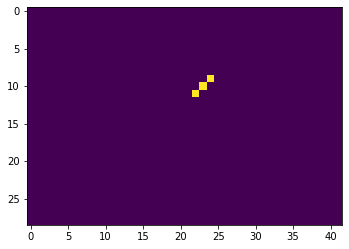

In [324]:
plt.imshow(pmasks[3])

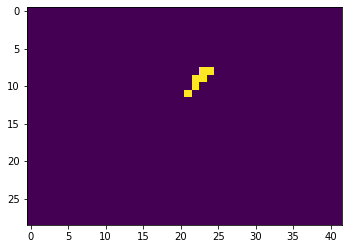

In [325]:
plt.imshow(pmasks[4])

In [243]:
profiles = {}
for k, v in intersections.items():
    try:
        profiles[k] = intersection_profiler.get_profile(k, v, 3) 
    except Exception:
        pass

In [252]:
%pdb

Automatic pdb calling has been turned ON


In [491]:
profiles = {}
for k in intersections:
    profiles[k] = intersection_profiler.get_profile(k, 3) 

/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [492]:
len(profiles)

6290

In [493]:
profiles[(3, 7)][2].shape

(5, 12)

In [442]:
def rectangulize_res(x):
    for (c1, c2), p in x.items():
        for id_m in range(p[2].shape[1]):
            for id_p in range(p[2].shape[0]):
                yield (c1, c2, id_m, id_p, p[2][id_p, id_m])

In [494]:
res_table = pd.DataFrame.from_records(
    rectangulize_res(profiles), columns=["cell_1", "cell_2", "marker_id", "position_id", "value"]
)

In [495]:
res_table

,cell_1,cell_2,marker_id,position_id,value
0,1,2,0,0,9770.400000
1,1,2,0,1,10820.250000
2,1,2,0,2,12767.800000
3,1,2,0,3,17211.600000
4,1,2,0,4,18421.000000
...,...,...,...,...,...
377395,11165,11168,11,0,875.100000
377396,11165,11168,11,1,897.333333
377397,11165,11168,11,2,900.700000
377398,11165,11168,11,3,888.300000


In [502]:
res_table.to_csv("profile_test_res.csv.gz", index=False)

/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [496]:
res_table["value"].isna().sum()

1140

In [497]:
res_table[res_table["value"].isna()]

,cell_1,cell_2,marker_id,position_id,value
108960,2917,2941,0,0,NaN
108961,2917,2941,0,1,NaN
108962,2917,2941,0,2,NaN
108963,2917,2941,0,3,NaN
108964,2917,2941,0,4,NaN
...,...,...,...,...,...
293452,8927,9025,10,2,NaN
293453,8927,9025,10,3,NaN
293456,8927,9025,11,1,NaN
293457,8927,9025,11,2,NaN


In [498]:
viewer_2 = napari.view_image(np.stack(profiles[(8927, 9025)][0][0]))

In [499]:
viewer_2.add_image(np.stack(profiles[(8927, 9025)][0][1]))

<Image layer 'Image [1]' at 0x1c5aae9e0>

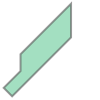

In [450]:
intersections[(11125, 11127)]

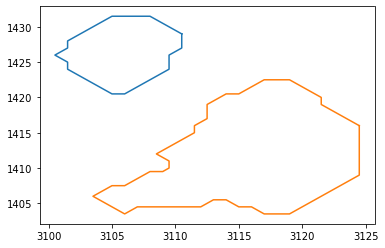

In [501]:
plt.plot(contours[11125][:, 0], contours[11125][:, 1])
plt.plot(contours[11127][:, 0], contours[11127][:, 1])

In [1015]:
i_mask

array([[ 8385.        ,   955.5       ,   181.25      ,   975.        ,
         4836.5       ,   787.        ,  1947.75      ,   369.5       ,
         5906.25      ,   864.        ,   266.25      ,   904.        ],
       [ 9416.5       ,   933.        ,   191.5       ,  1263.5       ,
         6045.        ,   875.        ,  2403.        ,   413.        ,
         6725.        ,   845.        ,   274.        ,   929.        ],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [12096.16666667,   958.33333333,   174.83333333,   635.        ,
         7841.        ,   675.5       ,  1391.5       ,   369.5       ,
         8442.83333333,   818.66666667,   265.83333333,   873.66666667],
       [11618.        ,   967.33333333,   192.        ,   962.66666667,
         7621.        ,   785.66666667,  1957.66666667,   39

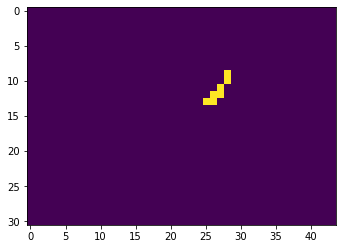

In [54]:
plt.imshow(pmasks[0])

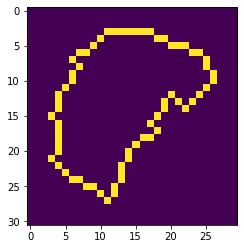

In [839]:
plt.imshow(i_mask[0][1])

In [830]:
i_mask

defaultdict(list,
            {0: [array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True],
                     [ True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True],
                     [ True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True, False, False, False, False, False, False, False,
                       True,  True,  True,  True,  True,  True,  True,  True,  True,
                       True,  True,  True],
                     [ True,  True,  True,  True,  True,  True,  True,  True,  Tru

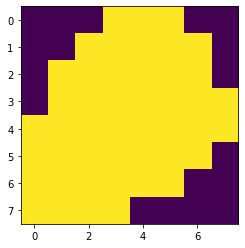

In [789]:
plt.imshow(i_mask)

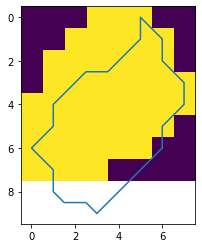

In [792]:
plt.imshow(i_mask)
plt.plot([x[0] for x in i_shape.exterior.coords], [x[1] for x in i_shape.exterior.coords])

In [430]:
i_shape.exterior.coords.

SyntaxError: invalid syntax (2806368971.py, line 1)

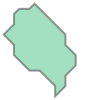

In [209]:
intersections[(3, 7)]

In [213]:
np.where(a)

(array([671, 671, 672, 672, 672, 672, 673, 673, 673, 673, 673, 673, 674,
        674, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 676,
        676, 676, 677, 677, 677, 678]),
 array([996, 997, 994, 995, 996, 997, 993, 994, 995, 996, 997, 998, 993,
        994, 995, 996, 997, 992, 993, 994, 995, 996, 997, 992, 993, 994,
        995, 996, 993, 994, 995, 994]))

In [211]:
a = rasterio.features.rasterize(
     [intersections[(3, 7)]], out_shape=sm.shape, fill=0
)

In [159]:
b = rasterio.features.rasterize(
     [x], out_shape=sm.shape, fill=0
)

In [162]:
x.bounds

(672.063492063492, 991.936507936508, 678.063492063492, 997.936507936508)

In [160]:
np.where(b)

(array([992, 993, 993, 994, 994, 995, 995, 996, 996, 997, 997]),
 array([677, 676, 677, 675, 676, 674, 675, 673, 674, 672, 673]))

In [212]:
viewer.add_image(a)
#viewer.add_image(b)

<Image layer 'a [4]' at 0x1dbe47d60>

In [157]:
import redseapy.redsea

In [158]:
redseapy.redsea.run_redsea(
    "exemplar-001/registration/exemplar-001.ome.tif",
    "exemplar-001/segmentation/unmicst-exemplar-001/cellMask.tif",
    "exemplar-001/markers.csv",
    "redsea_out"
)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [159]:
from shapely import speedups